<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/07_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata

## Задание 1. Выгрузка и предобработка данных
Выгрузите те же данные, что и для ДЗ с kNN-регрессией. Так мы сможем сравнить качество моделей на одних и тех же данных!

Воспользуйтесь запросом из 6 урока, чтобы выгрузить данные по объявлениям, созданным 30 января 2023 года. Помните, что поле `year` неправильного формата в исходной таблице, а также содержит нули (их нужно удалить из выборки). Также удалите объявления с ценой ниже 1000: как мы помним, это выбросы.

Целевую переменную прологарифмируйте.

Какое получилось среднее значение после преобразования?

Введите ответ с точностью до трех знаков после запятой

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
sql = """
SELECT
  la.*,
  log(la.price) as log_price,
  up.user_type_cars_name
FROM
  dp_live_adverts la
LEFT JOIN user_passports up on la.user_id = up.global_id
WHERE
  la.created_at::date = '2023-01-30' AND
  la.price > 1000 AND
  la.year != '0'
ORDER BY la.execution_date, la.advert_id
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
data

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,userType,log_price,user_type_cars_name
0,2023-01-30,271540910,2023-01-30 00:00:02,414000,Самара,134142241,ios,ЗАЗ,Chance,131631637,2014,0,12.933621,cars_simple
1,2023-01-30,271540911,2023-01-30 00:00:17,620000,Сочи,151328585,ios,Chevrolet,Cruze,144703780,2010,0,13.337475,cars_simple
2,2023-01-30,271540913,2023-01-30 00:01:21,4970000,Москва,123929189,android,Toyota,Land Cruiser,123950184,2013,6,15.418930,cars_seller
3,2023-01-30,271540914,2023-01-30 00:04:42,800000,Москва,137723514,android,Subaru,Impreza,134075141,2006,0,13.592367,cars_simple
4,2023-01-30,271540915,2023-01-30 00:04:57,280000,Пермь,142310446,android,Mitsubishi,RVR,137387157,1995,0,12.542545,cars_simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33065,2023-01-31,271590213,2023-01-30 23:49:14,10000,Новосибирск,138518294,android,Unknown,Unknown model,134630207,2007,0,9.210340,cars_simple
33066,2023-01-31,271590218,2023-01-30 23:49:54,480000,Новосибирск,135068367,ios,ВАЗ (Lada),Priora 2170 (седан),132241244,2012,0,13.081541,cars_simple
33067,2023-01-31,271590219,2023-01-30 23:50:18,1320000,Новосибирск,140623175,android,Chevrolet,Cobalt,136065423,2021,0,14.093142,cars_simple
33068,2023-01-31,271590226,2023-01-30 23:52:18,740000,Москва,148820047,desktop,Mercedes-Benz,C 320,143600166,2002,0,13.514405,cars_simple


In [ ]:
print(f"среднее значение log_price после преобразования = {data.log_price.mean():.3f}")

среднее значение log_price после преобразования = 13.303


## Задание 2. Подготовка признаков (1/2)
Для воспроизводимости результатов отсортируйте датафрейм по `['execution_date', 'advert_id']`.

Как и в прошлый раз, возьмем следующие фичи: `'region', 'platform', 'auto_brand', 'user_type_cars_name', 'year'`. Разделите признаки на категориальные и числовые.

Сколько категориальных признаков получилось?

In [ ]:
X = data[['region', 'platform', 'auto_brand', 'user_type_cars_name', 'year']]
y = data['log_price']

In [ ]:
X.year = X.year.astype(int)
X.select_dtypes(include='object').size
print(f"получилось {X.select_dtypes(include='object').shape[1]} категориальных признаков")

получилось 4 категориальных признаков


## Задание 2. Подготовка признаков (1/2)
Определим `X` и `y`. Затем разделим данные на обучающую и тестовую выборку в соотношении `4:1`. Зафиксируйте `random_seed=42`

Создайте `ColumnTransformer`, преобразующий все признаки в соответствии с их типом:

* для категориальных признаков используйте `OneHotEncoder(handle_unknown='ignore') (без drop='first')`.

* для числовых — `StandardScaler`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
col_transformer  = ColumnTransformer(
    transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), X.select_dtypes(include='object').columns),
    ('num', StandardScaler(), X.select_dtypes(exclude='object').columns)
],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
col_transformer.fit_transform(X_train).head()

,region_Волгоград,region_Воронеж,region_Екатеринбург,region_Ижевск,region_Казань,region_Калининград,region_Краснодар,region_Красноярск,region_Москва,region_Нижний Новгород,...,auto_brand_ЛуАЗ,auto_brand_Москвич,auto_brand_Ретро-автомобили,auto_brand_ТагАЗ,auto_brand_УАЗ,user_type_cars_name_,user_type_cars_name_cars_dealer,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple,year
12368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.080897
15555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.180276
1183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.180276
907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.080897
12964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.211026


## Задание 3. Дерево решений (1/4)
Создайте пайплайн с вашим `ColumnTransformer` и деревом регрессии в качестве модели. Не забудьте установить `random_state=42` как параметр дерева для воспроизводимости результатов.

С помощью гридсерча подберите следующие параметры:

* максимально допустимая глубина дерева `(значения 2, 10, 15, 20)`
* минимальное необходимое количество наблюдений в вершине для дальнейшего сплита `(значения 10, 200, 5000)`

В качестве метрики для гридсерча используйте отрицательную `MAE`.

Через запятую и пробел напишите, какие значения подобрались для параметров максимально допустимая глубина дерева и `min_samples_split`

In [ ]:
tree_pipe = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('decision_tree', DecisionTreeRegressor(random_state=42))
    ]
)


In [ ]:
%%time
tree_param_grid = {
    "decision_tree__max_depth": [2, 10, 15, 20],
    "decision_tree__min_samples_split": [10, 200, 5000]
}

tree_search = GridSearchCV(tree_pipe, tree_param_grid,
                           cv=None, scoring='neg_mean_absolute_error')

tree_search.fit(X_train, y_train)

print(f"Best parameter (CV score={tree_search.best_score_:.5f}):")
print(tree_search.best_params_)

Best parameter (CV score=-0.35043):
{'decision_tree__max_depth': 20, 'decision_tree__min_samples_split': 10}
CPU times: user 13.1 s, sys: 1.64 s, total: 14.8 s
Wall time: 20.5 s


In [ ]:
print(f"max_depth = {tree_search.best_params_['decision_tree__max_depth']}, min_samples_split = {tree_search.best_params_['decision_tree__min_samples_split']}")

max_depth = 20, min_samples_split = 10


## Задание 3. Дерево решений (2/4)
Прогоните лучшую модель на тестовой выборке и замерьте качество с помощью метрики R-squared (мы уже использовали ее раньше).

Какое значение получилось?

Округлите до 2 знаков после запятой

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(y_test, tree_search.best_estimator_.predict(X_test))

In [ ]:
print("R-squared:", round(r2, 2))

R-squared: 0.75


## Задание 3. Дерево решений (3/4)
Постройте график (`sns.barplot`) с важностью фичей для модели. Подсказка: достать названия фичей можно вот так

`pipeline.named_steps['column_transformer'].get_feature_names_out()`

Какая фича самая важная для этой модели?

In [ ]:
df_features_importance = pd.DataFrame({'feature': col_transformer.fit_transform(X_train).columns, 'importance': tree_search.best_estimator_['decision_tree'].feature_importances_}).sort_values(by='importance', ascending=False).head(10)

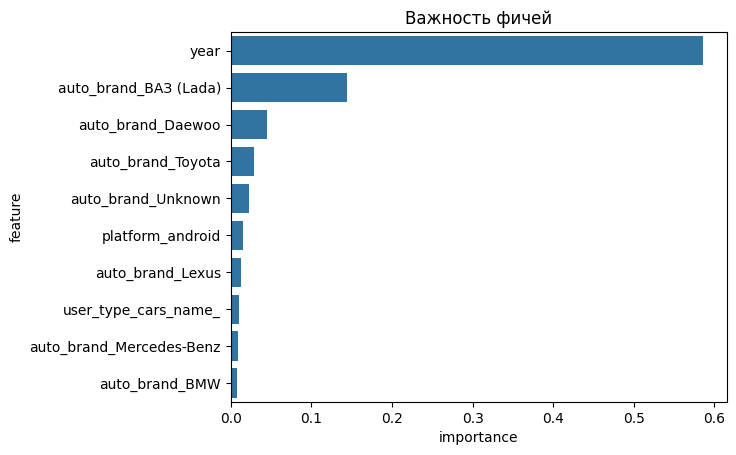

In [ ]:
sns.barplot(df_features_importance, x='importance', y='feature').set_title('Важность фичей');

In [ ]:
# создадим df важности фичей
df_features_importance_all = pd.DataFrame({'feature': col_transformer.fit_transform(X_train).columns, 'decision_tree': tree_search.best_estimator_['decision_tree'].feature_importances_})

## Задание 3. Случайный лес (1/2)
Давайте попробуем улучшить качество предсказания с помощью ансамблирования деревьев. Обучите случайный лес (не забудьте `random_state=42`), параметры для него подберите гридсерчем (в качестве метрики снова используйте отрицательную MAE):

максимальная глубина отдельного дерева (значения `2, 10, 15, 20`)
минимальное необходимое количество наблюдений в вершине для дальнейшего сплита (значения `10, 200, 5000`)
количество деревьев в ансамбле (`20, 50, 100`)
Замерьте качество с помощью `R-squared` и сравните с деревом решений. Стало ли лучше?

Обучите лучшую модель на тренировочной выборке и замерьте `R-squared` на тестовых данных.

Введите значение, округленное до двух знаков после запятой:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
random_forest_pipe = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('forest', RandomForestRegressor(random_state=42))
    ]
)

In [ ]:
%%time
forest_param_grid = {
    'forest__max_depth': [2, 10, 15, 20],
    'forest__min_samples_split': [10, 200, 5000],
    'forest__n_estimators': [20, 50, 100],

}

forest_search = GridSearchCV(random_forest_pipe, forest_param_grid,
                           cv=None, scoring='neg_mean_absolute_error')

forest_search.fit(X_train, y_train)

print(f"Best parameter (CV score={forest_search.best_score_:.5f}):")
print(forest_search.best_params_)

Best parameter (CV score=-0.33741):
{'forest__max_depth': 20, 'forest__min_samples_split': 10, 'forest__n_estimators': 100}
CPU times: user 8min 38s, sys: 5.01 s, total: 8min 43s
Wall time: 8min 47s


In [ ]:
r2 = r2_score(y_test, forest_search.best_estimator_.predict(X_test))

In [ ]:
print("R-squared:", round(r2, 2))

R-squared: 0.78


## Задание 3. Случайный лес (2/2)
Постройте график feature importance для случайного леса.

Изменились ли важные для модели фичи?

In [ ]:
df_features_importance = pd.DataFrame({'feature': col_transformer.fit_transform(X_train).columns, 'importance': forest_search.best_estimator_['forest'].feature_importances_}).sort_values(by='importance', ascending=False).head(10)

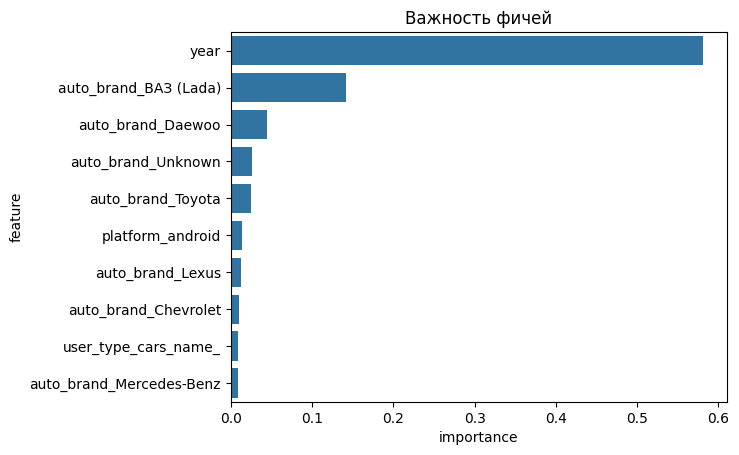

In [ ]:
sns.barplot(df_features_importance, x='importance', y='feature').set_title('Важность фичей');

In [ ]:
# дополним df важности фичей
df_features_importance_all["forest"] = forest_search.best_estimator_['forest'].feature_importances_

## Задание 4. Градиентный бустинг (1/5)
Обучите реализации градиентого бустинга, которые вы изучили на лекции - XGBRegressor (из библиотеки `xgboost`) и `CatBoostRegressor` (из библиотеки catboost). Для каждой из них:

1. Определите пайплайн с трансформами, как вы это делали в деревом решений и случайным лесом.

2. Обучите модель (без подбора параметров)

4. Замерьте время обучения модели. Это можно сделать с помощью модуля `time`. Пример реализации:

`%time pipeline.fit(X_train, y_train)`

5. Посчитайте `R-squared` на тестовой выборке

5. Постройте графики `feature importance`.

Для обеих моделей зафиксируйте `random_state=42`, а для `XGBoost дополнительно `n_jobs=1 и seed=0`

Какой вариант реализации отработал быстрее?

In [ ]:
!pip install xgboost --q
!pip install catboost --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from catboost import CatBoostRegressor

In [ ]:
xgboost_pipe = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('xgboost', xgb.XGBRegressor(random_state=42, n_jobs=1, seed=0))
    ]
)

In [ ]:
catboost_pipe = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('xgboost', CatBoostRegressor(random_state=42))
    ]
)

In [ ]:
%%time
xgboost_pipe.fit(X_train, y_train)

CPU times: user 1.29 s, sys: 15.7 ms, total: 1.31 s
Wall time: 1.98 s


Pipeline(steps=[('col_transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['region', 'platform', 'auto_brand', 'user_type_cars_name'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['year'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('xgboost',
                 XGBRegress...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
%%time
catboost_pipe.fit(X_train, y_train)

Learning rate set to 0.068697
0:	learn: 1.0643959	total: 60.9ms	remaining: 1m
1:	learn: 1.0246687	total: 67.3ms	remaining: 33.6s
2:	learn: 0.9882237	total: 76ms	remaining: 25.3s
3:	learn: 0.9552513	total: 81.9ms	remaining: 20.4s
4:	learn: 0.9253217	total: 92.3ms	remaining: 18.4s
5:	learn: 0.8981365	total: 121ms	remaining: 20.1s
6:	learn: 0.8732483	total: 137ms	remaining: 19.5s
7:	learn: 0.8508494	total: 153ms	remaining: 19s
8:	learn: 0.8307539	total: 170ms	remaining: 18.7s
9:	learn: 0.8114891	total: 188ms	remaining: 18.6s
10:	learn: 0.7944838	total: 209ms	remaining: 18.8s
11:	learn: 0.7799357	total: 221ms	remaining: 18.2s
12:	learn: 0.7660331	total: 236ms	remaining: 17.9s
13:	learn: 0.7524553	total: 253ms	remaining: 17.9s
14:	learn: 0.7407331	total: 267ms	remaining: 17.5s
15:	learn: 0.7305142	total: 277ms	remaining: 17s
16:	learn: 0.7212861	total: 290ms	remaining: 16.8s
17:	learn: 0.7130342	total: 300ms	remaining: 16.4s
18:	learn: 0.7056276	total: 312ms	remaining: 16.1s
19:	learn: 0.69

Pipeline(steps=[('col_transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['region', 'platform', 'auto_brand', 'user_type_cars_name'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['year'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('xgboost',
                 <catboost.core.CatBoostRegressor object at 0x7a228b18c790>)])

In [ ]:
r2_xb = r2_score(y_test, xgboost_pipe.predict(X_test))
r2_cb = r2_score(y_test, catboost_pipe.predict(X_test))

In [ ]:
print(f"xboost r2-score = {r2_xb:.3f}\ncatboost r2-score = {r2_cb:.3f}")

xboost r2-score = 0.768
catboost r2-score = 0.766


## Задание 4. Градиентный бустинг (4/5)
Посмотрите на соотношение важности фичей, которое получилось для этих моделей, сравните их с предыдущими графиками.

Что вы можете о них сказать? Отличаются ли они для этих моделей по сравнению с предыдущими?

In [ ]:
# дополним df важности фичей данными полученными после обучения xgboost и catboost
df_features_importance_all['xgboost'] = xgboost_pipe['xgboost'].feature_importances_
df_features_importance_all['catboost'] = catboost_pipe['xgboost'].feature_importances_

In [ ]:
#  для каждой модели проранжируем фичи по важности
df_ranked = df_features_importance_all.merge(df_features_importance_all[['decision_tree', 'forest', 'xgboost', 'catboost']].apply('rank'), left_index=True, right_index=True)

In [ ]:
# сделаем из широкого df длинный
plot_df = pd.melt(df_ranked, id_vars='feature', value_vars=['decision_tree_y',	'forest_y',	'xgboost_y',	'catboost_y']).sort_values(by='value', ascending=False)

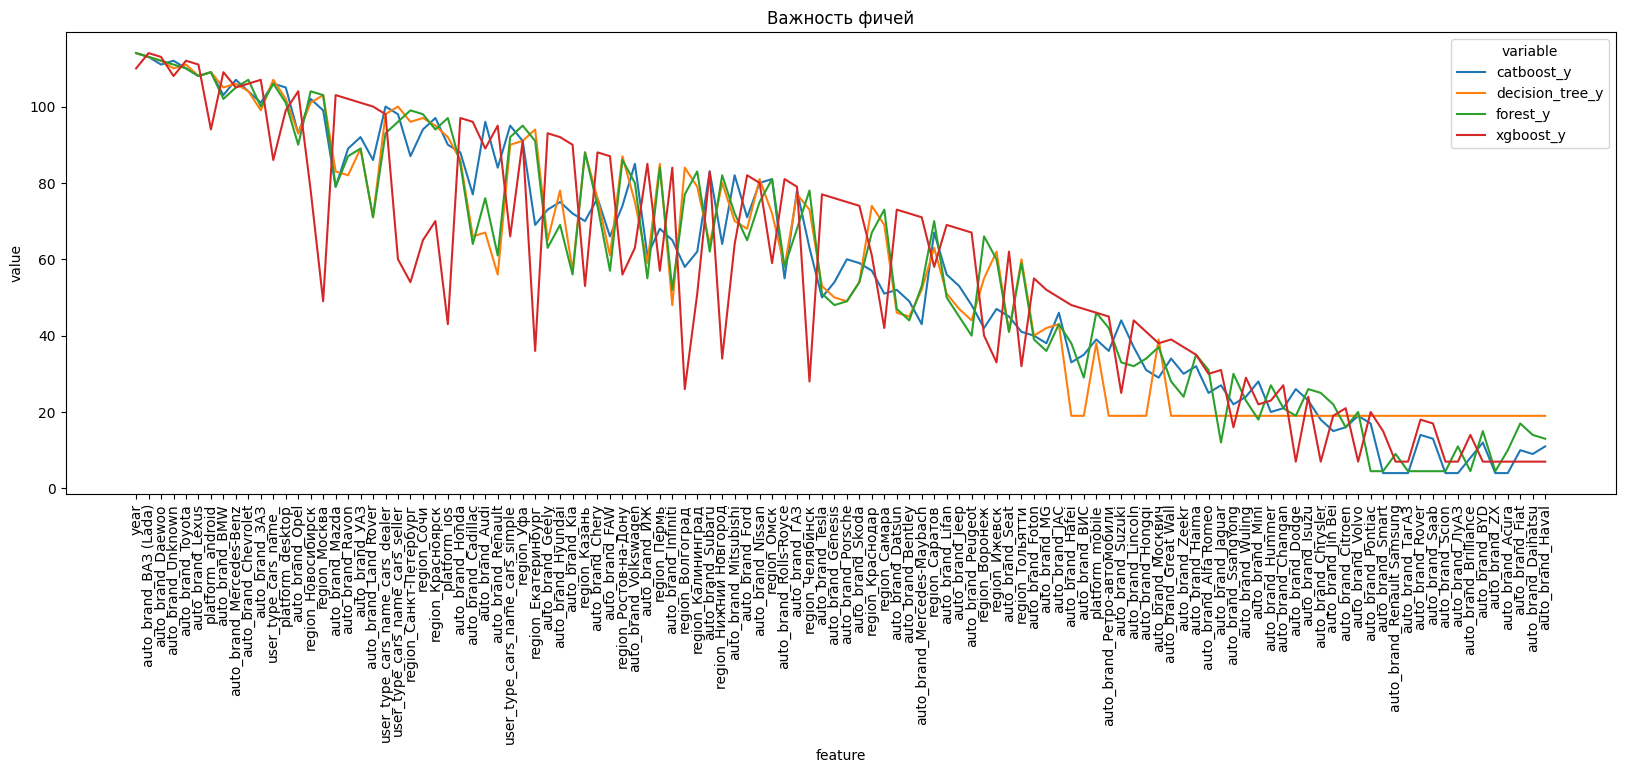

In [ ]:
# на графике видно, что xgboost отличается "провалами"
plt.figure(figsize=(20, 6))
sns.lineplot(plot_df, x='feature', y='value', hue='variable').set_title('Важность фичей')
plt.xticks(rotation=90);

✔ да, значительно отличается только у XGBoost, потому что только этот метод строит несимметричные деревья

## Задание 4. Градиентный бустинг (5/5)
1. Давайте выберем одну модель, в которую все-таки добавим признак `auto_model`.
* В прошлом мы не использовали его, потому что он имеет слишком много уникальных значений, и это мешает обычным линейным моделям находить решение.
* Однако сейчас мы знаем ансамбль, который может хорошо справиться с такими фичами. Что это за ансамбль (вернее, реализация)?

2. Обучите его, включив новый признак в число фичей для обучения. Не забудьте разделить выборку на `train` и `test` с зафиксированным `random_seed=42`. Пока используйте такой же пайплайн, как и до этого.

На сколько изменилась метрика `R-squared` по сравнению с лучшим скором из предыдущих шагов? Введите ответ, округлённый до тысячных, в поле ниже.

In [ ]:
X_ = data[['region', 'platform', 'auto_brand', 'user_type_cars_name', 'year', 'auto_model']]
y_ = data['log_price']

In [ ]:
X_.year = X_.year.astype(int)

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=42
)


In [ ]:
col_transformer  = ColumnTransformer(
    transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, ), X_.select_dtypes(include='object').columns),
    ('num', StandardScaler(), X.select_dtypes(exclude='object').columns)
],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
xgboost_pipe = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('xgboost', xgb.XGBRegressor(random_state=42, n_jobs=1, seed=0))
    ]
)

In [ ]:
xgboost_pipe.fit(X_train_, y_train_)

Pipeline(steps=[('col_transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['region', 'platform', 'auto_brand', 'user_type_cars_name',
       'auto_model'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['year'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('xgboos...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
r2_xb_ = r2_score(y_test_, xgboost_pipe.predict(X_test_))

In [ ]:
print(f"xboost r2-score = {r2_xb_:.3f}")

xboost r2-score = 0.795


In [ ]:
print(f"метрика R-squared изменилась на {r2_xb_ - r2_xb:.3f} по сравнению с лучшим скором из предыдущих шагов")

метрика R-squared изменилась на 0.027 по сравнению с лучшим скором из предыдущих шагов


### Дополнительно (без отправки ответа) попробуйте другой подход:

1. Создайте новый трансформер, который будет только применять `StandardScaler` к числовым признакам, и оставлять категориальные признаки как есть. Задайте `verbose_feature_names_out=False` и `set_output(transform='pandas')`.
2. Проверьте, как работает трансформер.
3. Создайте пайплайн, использующий этот трансформер и бустинг.
* Для бустинга в параметр `cat_features` передайте названия категориальных переменных.
* Как и раньше, обучите модель на обучающей выборке, проверьте качество на тестовой. В данном случае, такой подход не дал преимущества по качеству. В других ситуациях он может работать намного лучше, чем использование `One-Hot Encoding`.
4. Посмотрите важности признаков (и обратите внимание, как изменилось количество признаков на графике).

In [ ]:
col_transformer_  = ColumnTransformer(
    transformers=[
    ('num', StandardScaler(), X.select_dtypes(exclude='object').columns)
],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
col_transformer_.fit_transform(X_).head()

,year,region,platform,auto_brand,user_type_cars_name,auto_model
0,0.909204,Самара,ios,ЗАЗ,cars_simple,Chance
1,0.511826,Сочи,ios,Chevrolet,cars_simple,Cruze
2,0.809860,Москва,android,Toyota,cars_seller,Land Cruiser
3,0.114449,Москва,android,Subaru,cars_simple,Impreza
4,-0.978340,Пермь,android,Mitsubishi,cars_simple,RVR


In [ ]:
cat_features = X_.select_dtypes(include='object').columns.to_list()

In [ ]:
cat_features

['region', 'platform', 'auto_brand', 'user_type_cars_name', 'auto_model']

In [ ]:
xgboost_pipe_ = Pipeline(
    [
        ("col_transformers", col_transformer),
        ('xgboost', xgb.XGBRegressor(random_state=42, n_jobs=1, seed=0, cat_features=cat_features))
    ]
)

In [ ]:
xgboost_pipe_.fit(X_train_, y_train_)

Pipeline(steps=[('col_transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['region', 'platform', 'auto_brand', 'user_type_cars_name',
       'auto_model'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['year'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('xgboos...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=1,
                              num_parallel_tree=None, ...))])

In [ ]:
r2_xb_2 = r2_score(y_test_, xgboost_pipe_.predict(X_test_))

In [ ]:
print(f"xboost with cat features r2-score = {r2_xb_2:.3f}")

xboost with cat features r2-score = 0.795


In [ ]:
df_features_importance_xb = pd.DataFrame({'feature': xgboost_pipe_['xgboost'].feature_names_in_, 'importance': xgboost_pipe_['xgboost'].feature_importances_}).sort_values(by='importance', ascending=False).head(100)

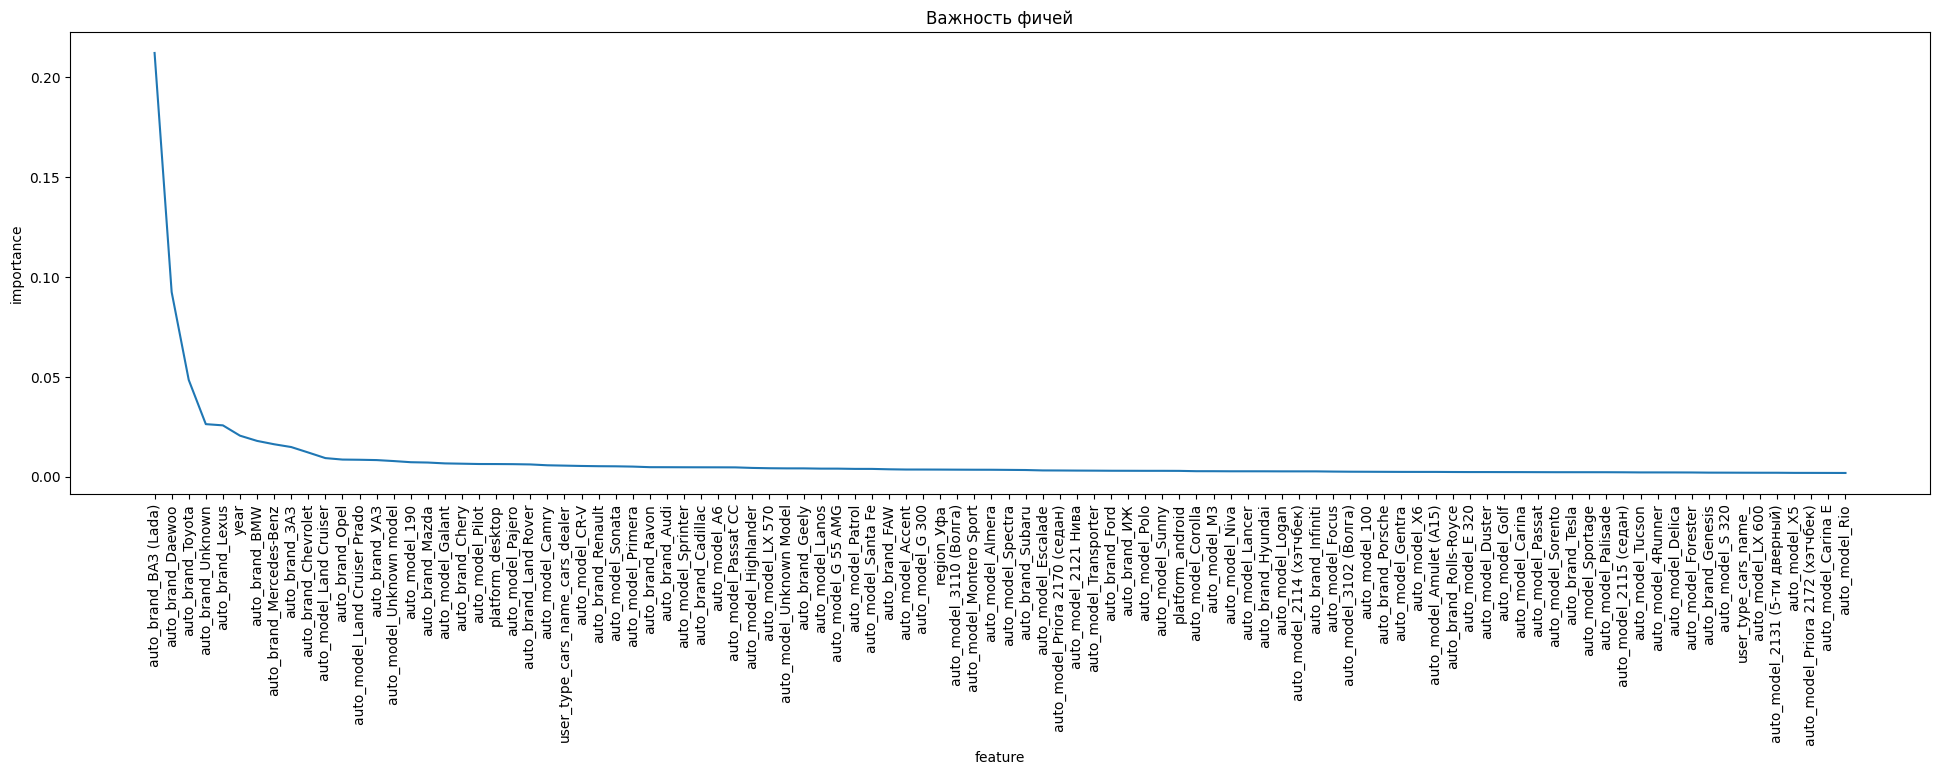

In [ ]:
plt.figure(figsize=(24, 6))
sns.lineplot(df_features_importance_xb, x='feature', y='importance').set_title('Важность фичей')
plt.xticks(rotation=90);

подозреваю, что то, что признак является ли авто ВАЗ Lada самым важным для модели не говорит ничего хорошего об этом авто)